In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('D:/bio/metirc/scib-main')
os.environ['R_HOME'] = "E:/R/R-4.2.1/"
os.environ['R_USER'] = "D:/anaconda/envs/index/Lib/site-packages/rpy2"
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad 
import scib
import index

In [2]:
def load_data(file_paths):
    adata_list = []
    for file_path in file_paths:
        adata_temp = sc.read_h5ad(file_path)
        adata_list.append(adata_temp)
    return adata_list

def load_data_merge(file_paths, samples):
    adata_list = []
    for file_path in file_paths:
        adata_temp = sc.read_h5ad(file_path)
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        adata_list.append(adata_temp)
    adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
    return adata_pre

def load_data_visium_label(file_paths):
    adata_list = []
    for file_path in file_paths:
        adata_temp = sc.read_visium(file_path)
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        adata_label = pd.read_csv(file_path + '/truth.csv', index_col=0)
        adata_temp.obs['batch'] = adata_label['batch'].astype("category")
        adata_temp.obs['ground.truth'] = adata_label['ground.truth'].astype("category")
        adata_list.append(adata_temp)
    return adata_list

In [3]:
samples = [str(i) for i in range(151507, 151511)]
method = 'seurat'
input_dir = 'G:/dataset/1_DLPFC/input/'
output_dir = 'G:/dataset/1_DLPFC/output/donor1/'
adata_list = load_data_visium_label([ input_dir+sample  for sample in samples])
adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)

if method in ['DeepST', 'STAGATE', 'STAligner']:
    embedding_pd = pd.read_csv(output_dir + method + '/embedding.csv', header = None)
else:
    embedding_pd = pd.read_csv(output_dir + method + '/embedding.csv', index_col = 0)
print(embedding_pd.shape)
print(embedding_pd.iloc[: , :3])
if adata_pre.shape[0] == embedding_pd.shape[0]:
    adatas = adata_pre
else:
    # PRECAST
    embedding_pd.rename(index=lambda s: s[:len(s)-1]+'-'+samples[int(s[-1])-1], inplace=True)
    print(embedding_pd.iloc[: , :3].head())
    adatas = adata_pre[embedding_pd.index.to_list(), :]
assert adatas.shape[0] == embedding_pd.shape[0], 'check shape'
adatas.obsm[method+'_embedding'] = embedding_pd.values
print(adatas)


adatas = adatas[adatas.obs['ground.truth']!='']
adatas = adatas[adatas.obs['ground.truth']!='na']
adatas = adatas[adatas.obs['ground.truth']!='unknown']

groups = adatas.obs.groupby("batch").indices
adata_list = [adatas[inds] for inds in groups.values()]
adata_list.insert(0, adatas)
del adata_pre

D:\anaconda\envs\index\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\index\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\index\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\index\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\index\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn

FileNotFoundError: [Errno 2] No such file or directory: 'G:/dataset/1_DLPFC/output/donor1/seurat/embedding.csv'

In [4]:
for adata in adata_list:
    if 'GraphST' == method:
        sc.pp.neighbors(adata, n_neighbors=50, use_rep= method+'_embedding')
    else:
        sc.pp.neighbors(adata, use_rep= method+'_embedding')
    # leiden
    adata = index.get_cluster_data(adata, 7, True, 'leiden', 'leiden_'+method, resolution = sorted(list(np.arange(0.1, 0.4, 0.01)), reverse=True))
    # louvain
    adata = index.get_cluster_data(adata, 7, True, 'louvain', 'louvain_'+method, resolution = sorted(list(np.arange(0.1, 0.4, 0.01)), reverse=True))
    # mclust
    adata = index.get_cluster_data(adata, 7, True, 'mclust', 'mclust_'+method, None, method+'_embedding')


resolution:  0.3999999999999998    count_unique_leiden:  11
resolution:  0.3899999999999999    count_unique_leiden:  10
resolution:  0.3799999999999999    count_unique_leiden:  10
resolution:  0.3699999999999999    count_unique_leiden:  10
resolution:  0.3599999999999999    count_unique_leiden:  11
resolution:  0.34999999999999987    count_unique_leiden:  11
resolution:  0.33999999999999986    count_unique_leiden:  10
resolution:  0.32999999999999985    count_unique_leiden:  10
resolution:  0.3199999999999999    count_unique_leiden:  10
resolution:  0.30999999999999994    count_unique_leiden:  10
resolution:  0.29999999999999993    count_unique_leiden:  10
resolution:  0.2899999999999999    count_unique_leiden:  9
resolution:  0.2799999999999999    count_unique_leiden:  9
resolution:  0.2699999999999999    count_unique_leiden:  8
resolution:  0.2599999999999999    count_unique_leiden:  6
resolution:  0.24999999999999992    count_unique_leiden:  7
Best resolution:  0.24999999999999992
r

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |                                                                      |   0%

D:\anaconda\envs\index\lib\site-packages\rpy2\robjects\numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%
resolution:  0.3999999999999998    count_unique_leiden:  11
resolution:  0.3899999999999999    count_unique_leiden:  11
resolution:  0.3799999999999999    count_unique_leiden:  10
resolution:  0.3699999999999999    count_unique_leiden:  11
resolution:  0.3599999999999999    count_unique_leiden:  11
resolution:  0.34999999999999987    count_unique_leiden:  11
resolution:  0.33999999999999986    count_unique_leiden:  11
resolution:  0.32999999999999985    count_unique_leiden:  11
resolution:  0.3199999999999999    count_unique_leiden:  10
resolution:  0.30999999999999994    count_unique_leiden:  10
resolution:  0.29999999999999993    count_unique_leiden:  10
resolution:  0.2899999999999999    count_unique_leiden:  10
resolution:  0.2799999999999999    count_unique_leiden:  9
resolution:  0.2699999999999999    count_unique_leiden:  9
resolution:  0.2599999999999999    count_unique_leiden:  9
resolution:  0.249

D:\anaconda\envs\index\lib\site-packages\rpy2\robjects\numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%
resolution:  0.3999999999999998    count_unique_leiden:  12
resolution:  0.3899999999999999    count_unique_leiden:  11
resolution:  0.3799999999999999    count_unique_leiden:  11
resolution:  0.3699999999999999    count_unique_leiden:  11
resolution:  0.3599999999999999    count_unique_leiden:  9
resolution:  0.34999999999999987    count_unique_leiden:  11
resolution:  0.33999999999999986    count_unique_leiden:  9
resolution:  0.32999999999999985    count_unique_leiden:  9
resolution:  0.3199999999999999    count_unique_leiden:  9
resolution:  0.30999999999999994    count_unique_leiden:  9
resolution:  0.29999999999999993    count_unique_leiden:  9
resolution:  0.2899999999999999    count_unique_leiden:  9
resolution:  0.2799999999999999    count_unique_leiden:  9
resolution:  0.2699999999999999    count_unique_leiden:  9
resolution:  0.2599999999999999    count_unique_leiden:  8
resolution:  0.2499999999

D:\anaconda\envs\index\lib\site-packages\rpy2\robjects\numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%
resolution:  0.3999999999999998    count_unique_leiden:  6
resolution:  0.3899999999999999    count_unique_leiden:  6
resolution:  0.3799999999999999    count_unique_leiden:  6
resolution:  0.3699999999999999    count_unique_leiden:  6
resolution:  0.3599999999999999    count_unique_leiden:  6
resolution:  0.34999999999999987    count_unique_leiden:  6
resolution:  0.33999999999999986    count_unique_leiden:  6
resolution:  0.32999999999999985    count_unique_leiden:  6
resolution:  0.3199999999999999    count_unique_leiden:  5
resolution:  0.30999999999999994    count_unique_leiden:  5
resolution:  0.29999999999999993    count_unique_leiden:  5
resolution:  0.2899999999999999    count_unique_leiden:  5
resolution:  0.2799999999999999    count_unique_leiden:  5
resolution:  0.2699999999999999    count_unique_leiden:  4
resolution:  0.2599999999999999    count_unique_leiden:  5
resolution:  0.249999999999999

D:\anaconda\envs\index\lib\site-packages\rpy2\robjects\numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%
resolution:  0.3999999999999998    count_unique_leiden:  12
resolution:  0.3899999999999999    count_unique_leiden:  12
resolution:  0.3799999999999999    count_unique_leiden:  11
resolution:  0.3699999999999999    count_unique_leiden:  11
resolution:  0.3599999999999999    count_unique_leiden:  10
resolution:  0.34999999999999987    count_unique_leiden:  11
resolution:  0.33999999999999986    count_unique_leiden:  10
resolution:  0.32999999999999985    count_unique_leiden:  10
resolution:  0.3199999999999999    count_unique_leiden:  10
resolution:  0.30999999999999994    count_unique_leiden:  10
resolution:  0.29999999999999993    count_unique_leiden:  9
resolution:  0.2899999999999999    count_unique_leiden:  10
resolution:  0.2799999999999999    count_unique_leiden:  8
resolution:  0.2699999999999999    count_unique_leiden:  8
resolution:  0.2599999999999999    count_unique_leiden:  9
resolution:  0.2499

D:\anaconda\envs\index\lib\site-packages\rpy2\robjects\numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%


In [11]:
adata = sc.read_h5ad(r'G:\dataset\05-LICA\output\result\embedding\seurat_K4_result.h5ad')
adata

AnnData object with n_obs × n_vars = 15264 × 33538
    obs: 'batch', 'region', 'leiden', 'leiden_seurat', 'louvain', 'louvain_seurat', 'mclust_seurat', 'silhouette_temp'
    var: 'highly_variable'
    uns: 'ARI_leiden_seurat', 'ARI_louvain_seurat', 'ARI_mclust_seurat', 'ARI_region', 'IsolatedLabelsAsw_celltypeseurat', 'IsolatedLabelsAsw_leiden_seurat', 'IsolatedLabelsAsw_louvain_seurat', 'IsolatedLabelsAsw_mclust_seurat', 'IsolatedLabelsF1_celltypeseurat', 'IsolatedLabelsF1_leiden_seurat', 'IsolatedLabelsF1_louvain_seurat', 'IsolatedLabelsF1_mclust_seurat', 'NMI_leiden_seurat', 'NMI_louvain_seurat', 'NMI_mclust_seurat', 'NMI_region', 'PCRseurat', 'cASW_celltypeseurat', 'cASW_leiden_seurat', 'cASW_louvain_seurat', 'cASW_mclust_seurat', 'cLISI_celltypeseurat', 'cLISI_leiden_seurat', 'cLISI_louvain_seurat', 'cLISI_mclust_seurat', 'gearysC_seurat', 'graph_connectivity_celltypeseurat', 'graph_connectivity_leiden_seurat', 'graph_connectivity_louvain_seurat', 'graph_connectivity_mclust_seurat

[<Axes: title={'center': 'batch'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'batch'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'region'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'leiden_seurat'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'louvain_seurat'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'mclust_seurat'}, xlabel='spatial1', ylabel='spatial2'>]

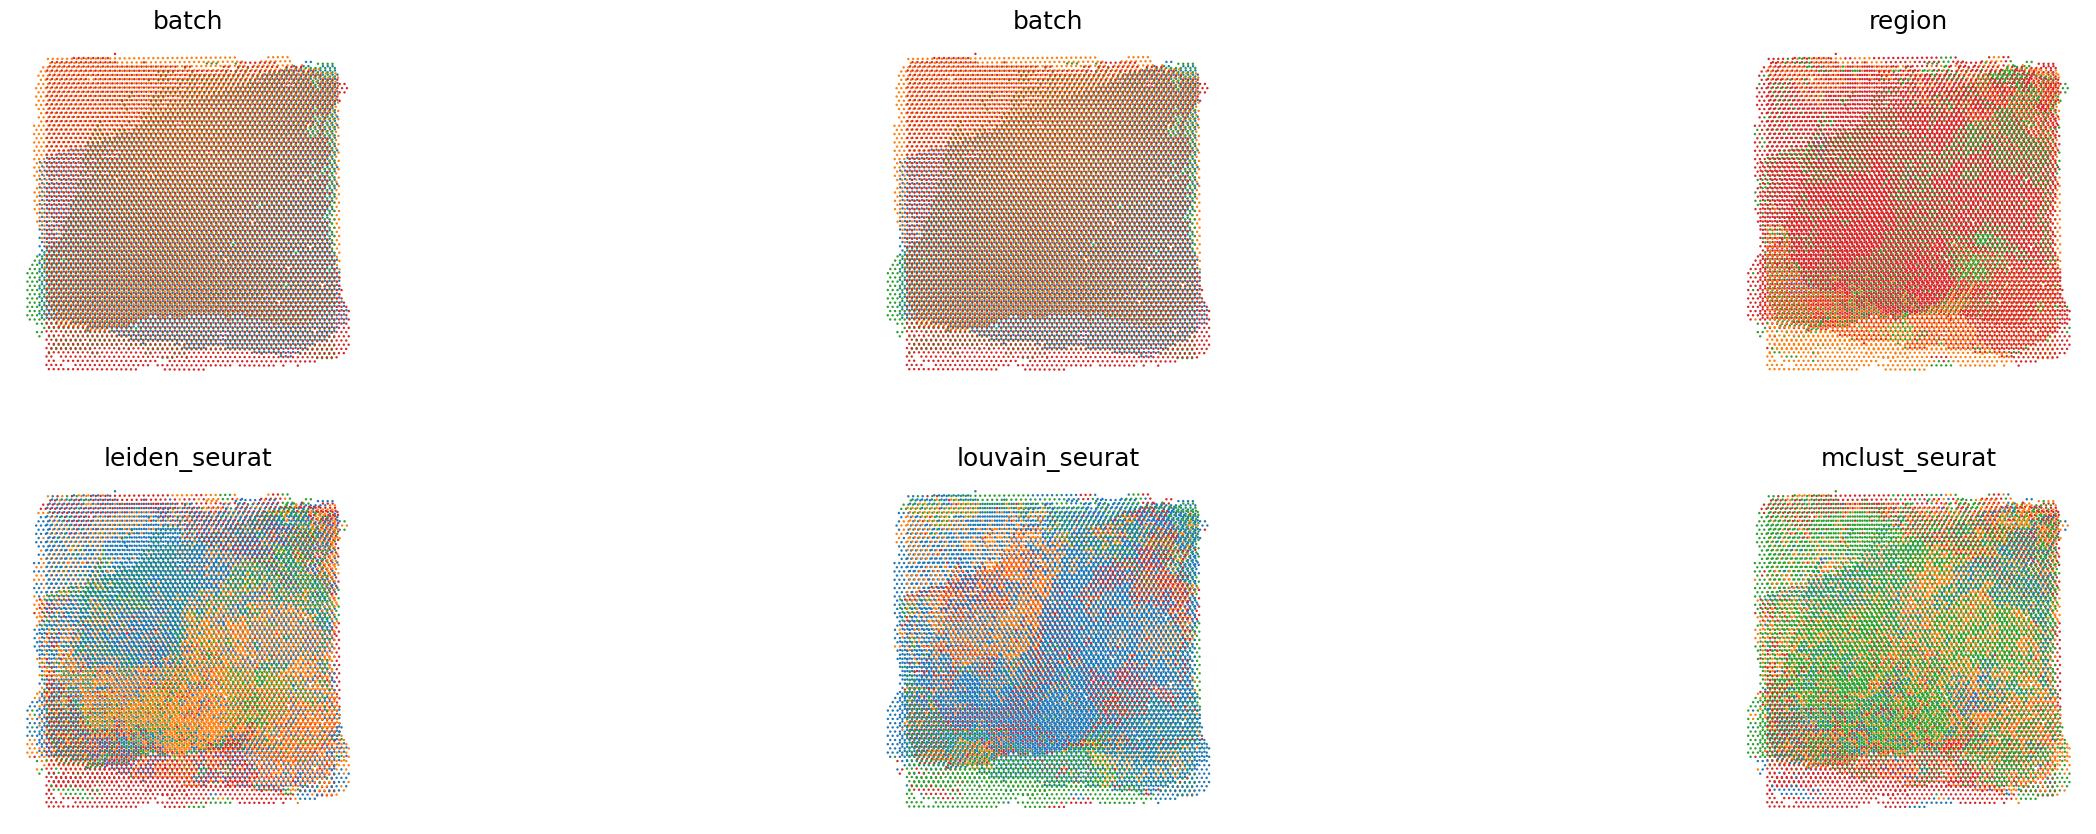

In [16]:
sc.pl.spatial(adata, color=['batch', 'batch', 'region', 'leiden_seurat', 'louvain_seurat', 'mclust_seurat'], ncols=3,
                  wspace=0.5, show=False, legend_loc= None, frameon=False, 
                  img_key='hires', spot_size=100)

In [5]:
for adata in adata_list:
    adata.obsm['X_pca'] = adata.obsm[method+'_embedding']
    sc.tl.umap(adata)
    sc.tl.tsne(adata)
    
#     if method == 'STAligner':
#         sc.tl.umap(adata, random_state=666)
#         sc.tl.tsne(adata, random_state=666)

['integrated', 'D1_151507', 'D1_151508', 'D1_151509', 'D1_151510']


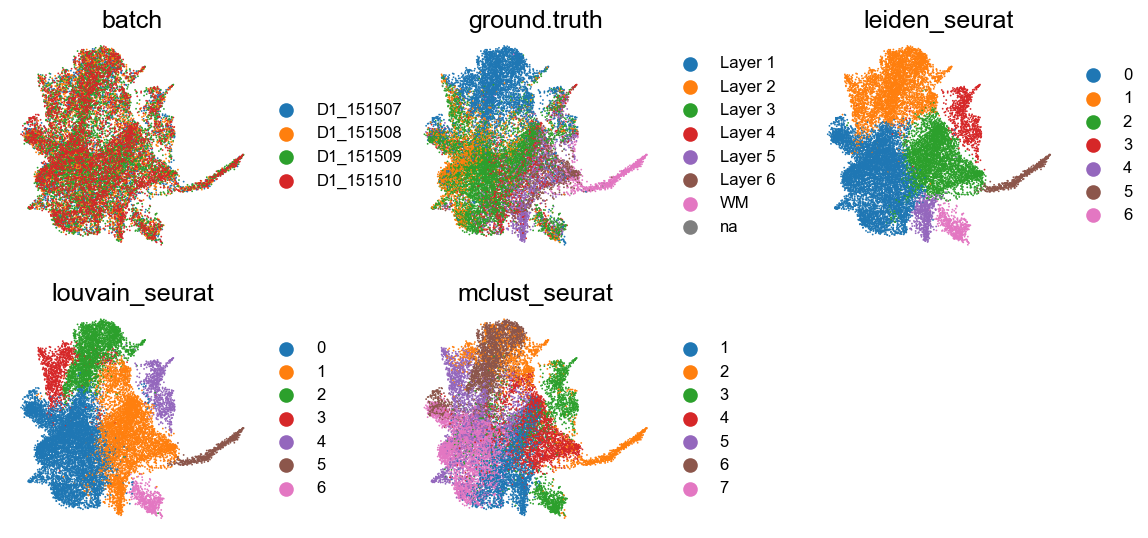

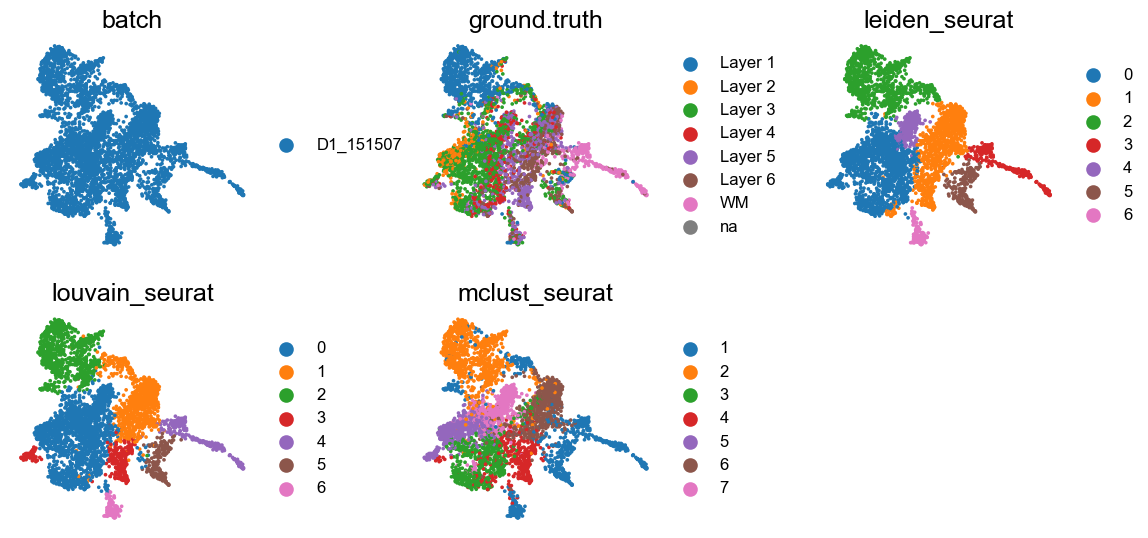

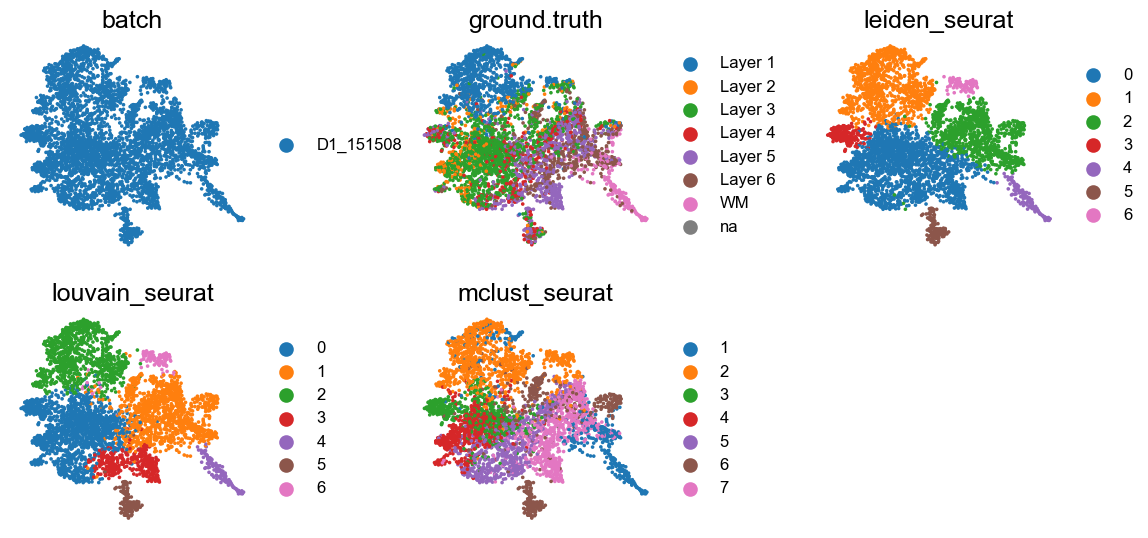

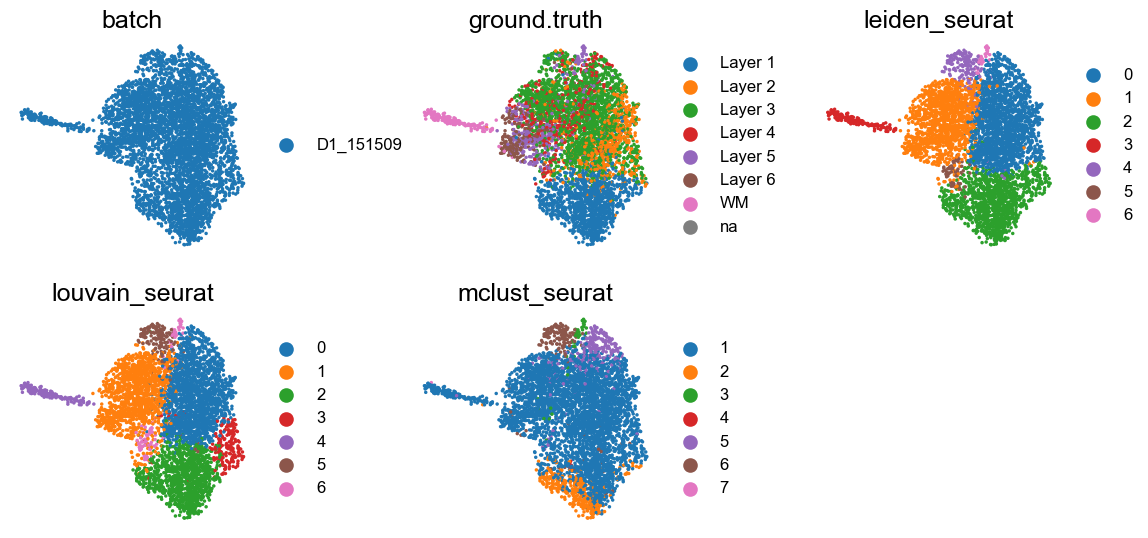

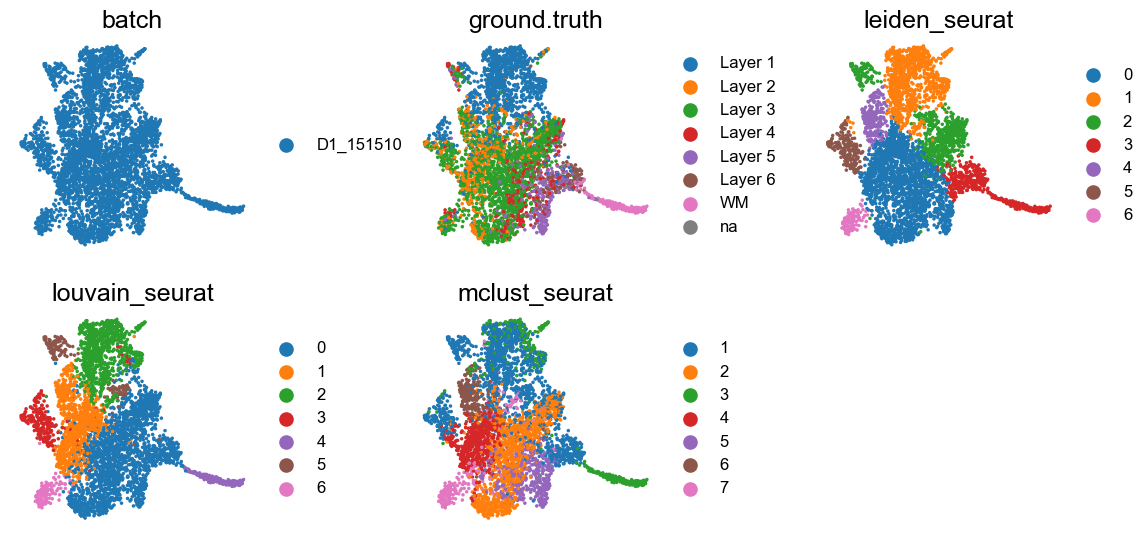

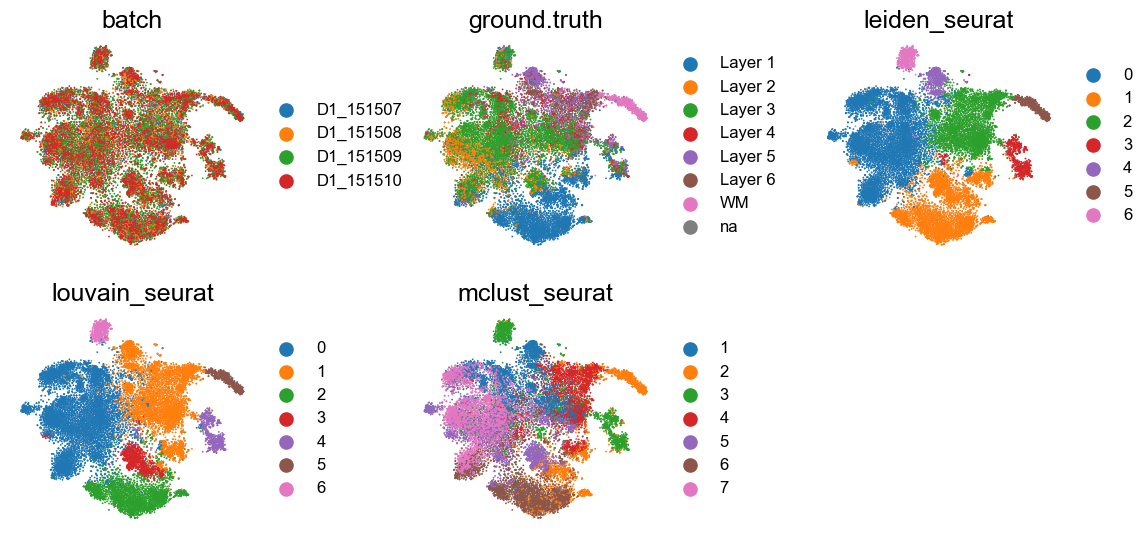

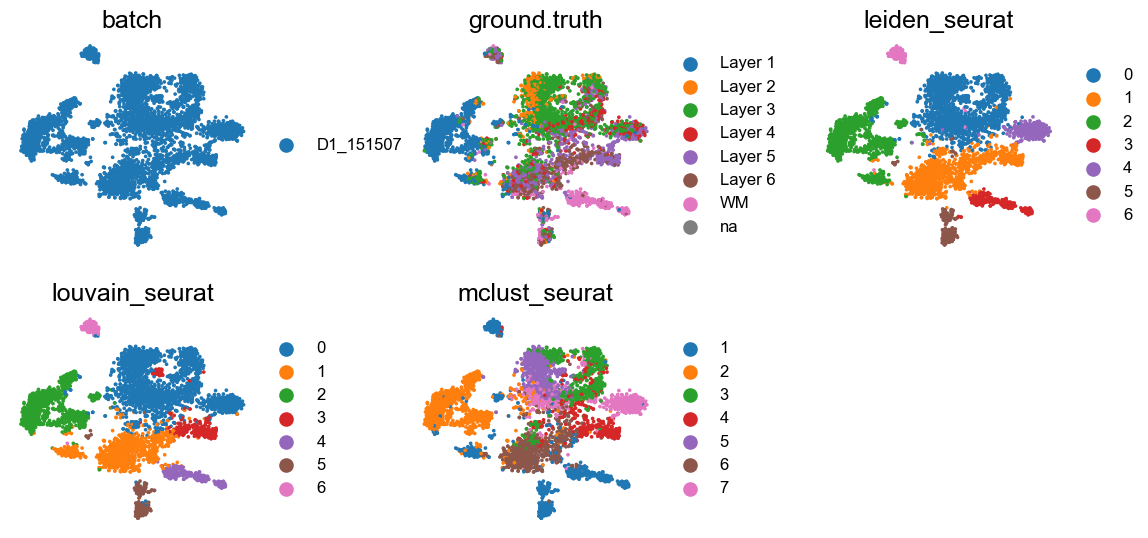

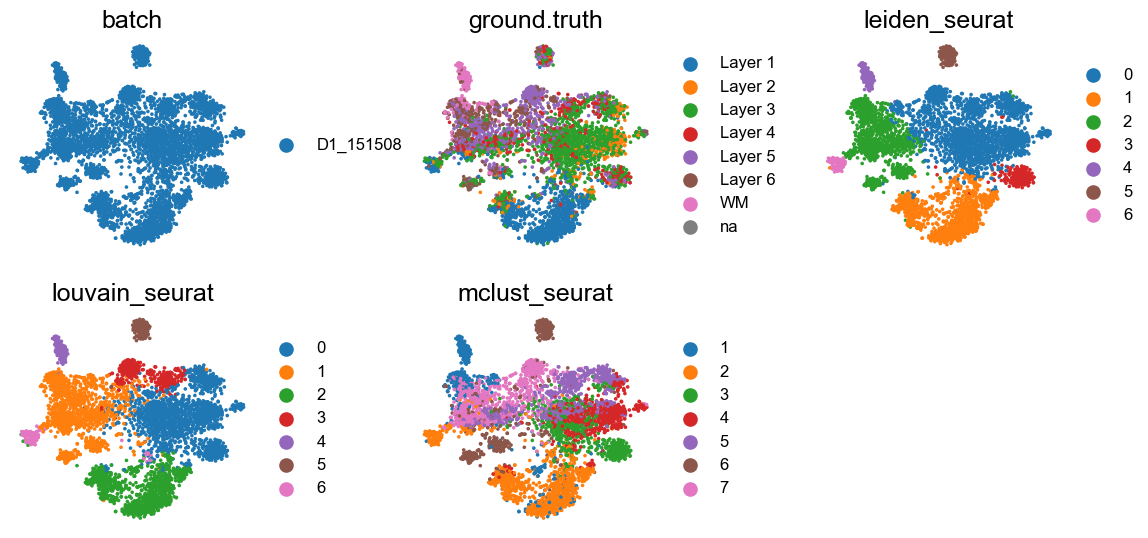

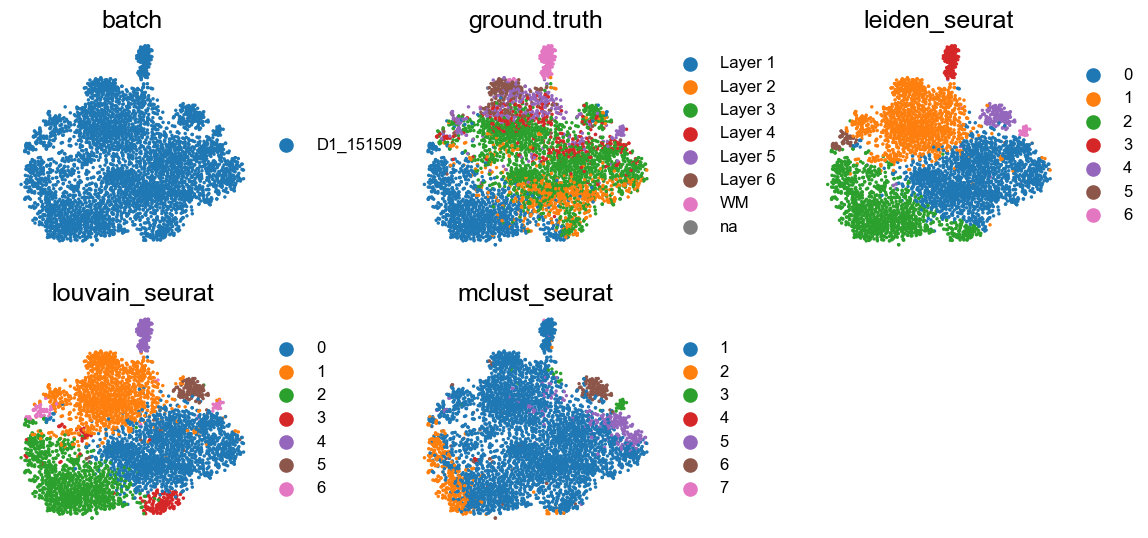

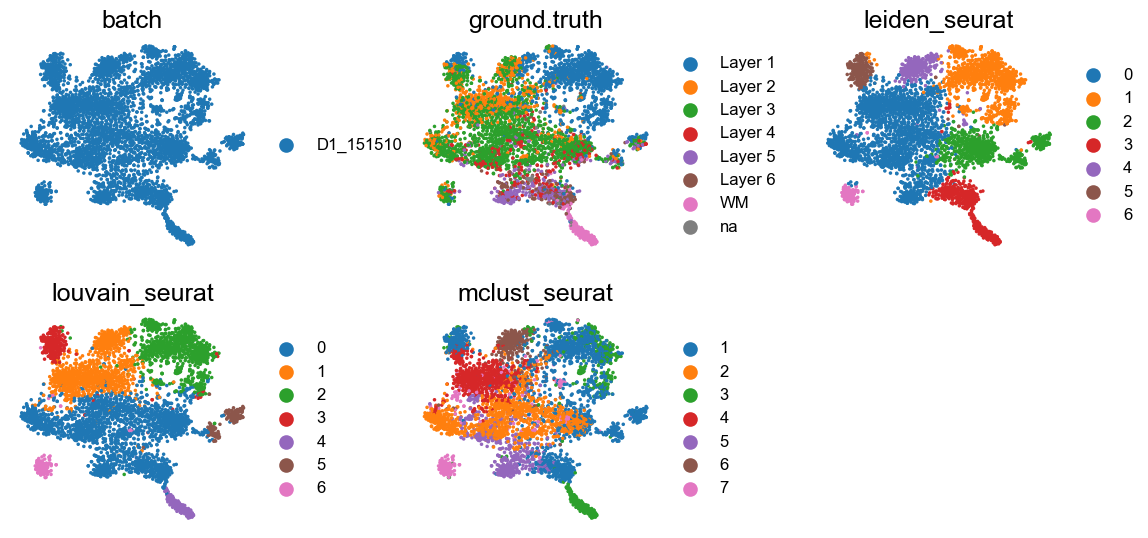

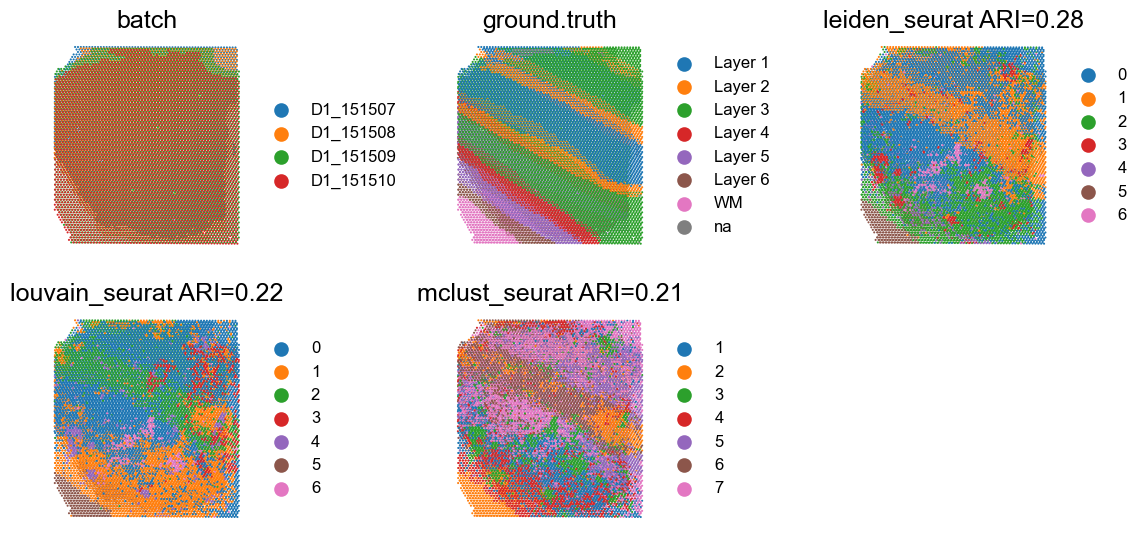

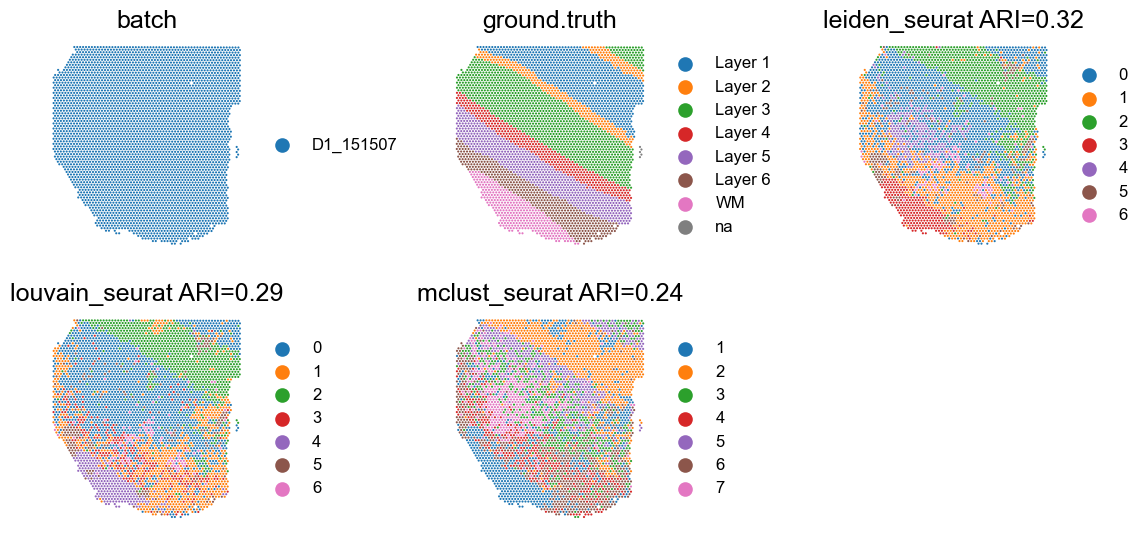

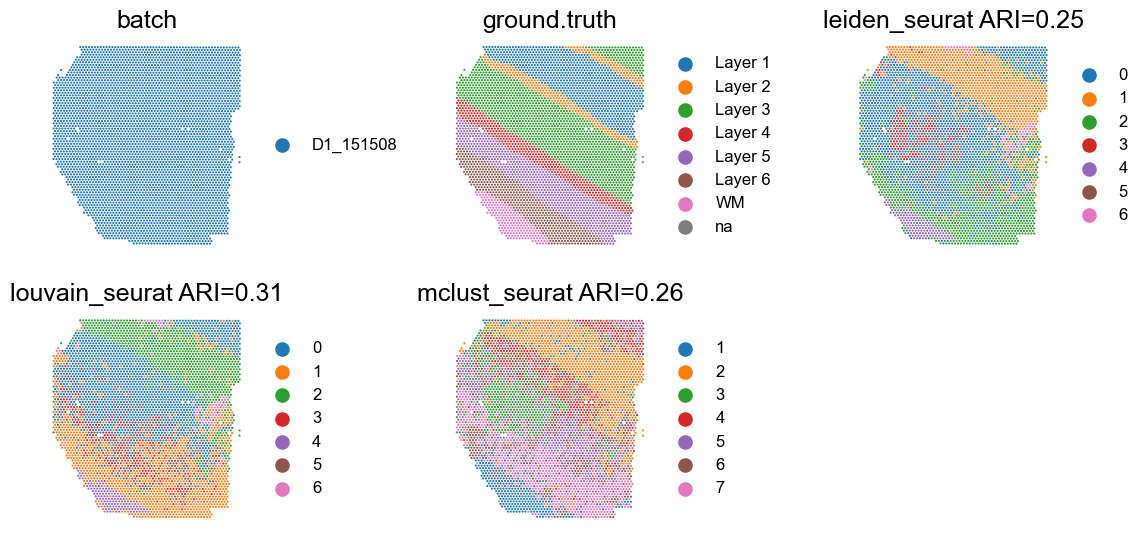

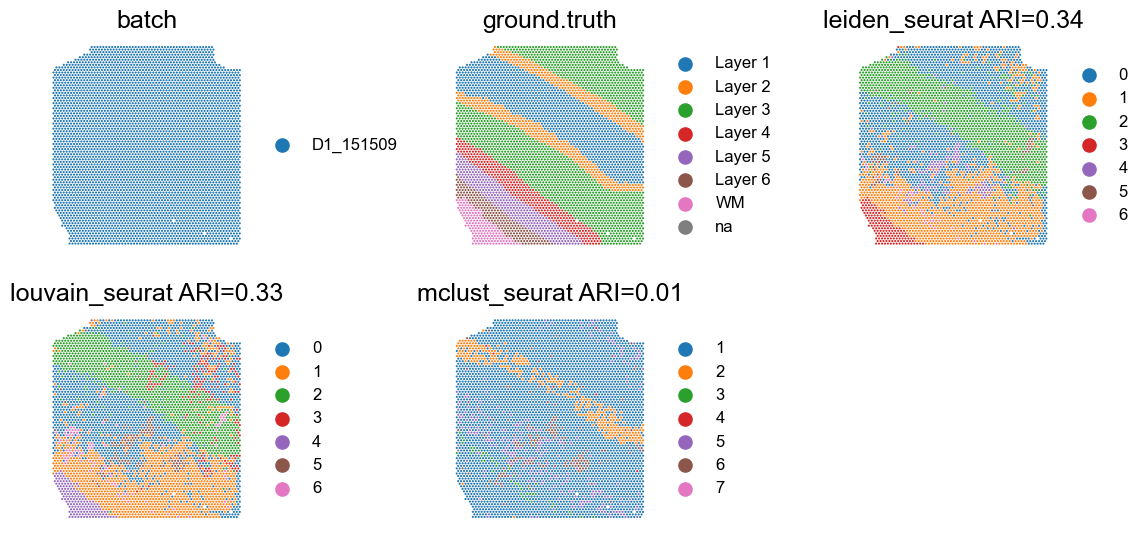

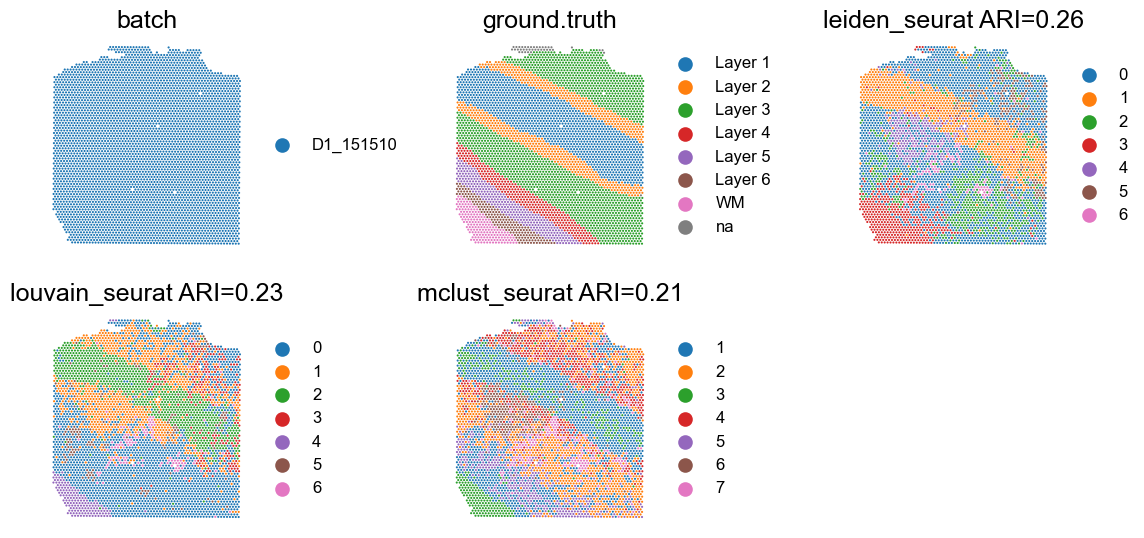

In [43]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

samples = [inds for inds in groups.keys()]
plt_obs = ['batch', 'ground.truth', 'leiden_'+method, 'louvain_'+method, 'mclust_'+method]
samples.insert(0, 'integrated')
print(samples)
for i in range(len(adata_list)):
    sc.pl.umap(adata_list[i], color=['batch', 'ground.truth', 'leiden_seurat', 'louvain_seurat', 'mclust_seurat'], ncols=3,
               wspace=0.5, show=False, legend_fontsize=12, legend_fontoutline=2, frameon=False)
    plt.savefig(output_dir + method + '_' + samples[i] + '_umap.png', dpi=300)

for i in range(len(adata_list)):
    sc.pl.tsne(adata_list[i], color=['batch', 'ground.truth', 'leiden_seurat', 'louvain_seurat', 'mclust_seurat'], ncols=3,
               wspace=0.5, show=False, legend_fontsize=12, legend_fontoutline=2, frameon=False)
    plt.savefig(output_dir + method + '_' + samples[i] + '_tsne.png', dpi=300)

for i in range(len(adata_list)):
    titles = ['batch', 'ground.truth']
    titles.append(plt_obs[2] + ' ARI=' + str( round(index.ARI(adata_list[i], 'leiden_'+method, 'ground.truth'), 2) ))
    titles.append(plt_obs[3] + ' ARI=' + str(round(index.ARI(adata_list[i], 'louvain_'+method, 'ground.truth'), 2)))
    titles.append(plt_obs[4] + ' ARI=' + str(round(index.ARI(adata_list[i], 'mclust_'+method, 'ground.truth'), 2)))
    sc.pl.spatial(adata_list[i], color=['batch', 'ground.truth', 'leiden_seurat', 'louvain_seurat', 'mclust_seurat'], ncols=3,
                  wspace=0.5, show=False, legend_fontsize=12, legend_fontoutline=2, frameon=False, 
                  img_key='hires', spot_size=100, title=titles)
    plt.savefig(output_dir + method + '_' + samples[i] + '_spatial.png', dpi=300)

In [38]:
for i in range(len(adata_list)):
    del adata_list[i].X
    adata_list[i].write(output_dir + method + '_' + samples[i] + '.h5ad')

In [ ]:
## all in a code


import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('D:/bio/metirc/scib-main')
os.environ['R_HOME'] = "E:/R/R-4.2.1/"
os.environ['R_USER'] = "D:/anaconda/envs/index/Lib/site-packages/rpy2"
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad 
import scib
import index

def load_data(file_paths):
    adata_list = []
    for file_path in file_paths:
        adata_temp = sc.read_h5ad(file_path)
        adata_list.append(adata_temp)
    return adata_list

def load_data_merge(file_paths, samples):
    adata_list = []
    for file_path in file_paths:
        adata_temp = sc.read_h5ad(file_path)
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        adata_list.append(adata_temp)
    adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
    return adata_pre

def load_data_visium_label(file_paths):
    adata_list = []
    for file_path in file_paths:
        adata_temp = sc.read_visium(file_path)
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        adata_label = pd.read_csv(file_path + '/truth.csv', index_col=0)
        adata_temp.obs['batch'] = adata_label['batch'].astype("category")
        adata_temp.obs['ground.truth'] = adata_label['ground.truth'].astype("category")
        adata_list.append(adata_temp)
    return adata_list


for method in methods:
    samples = [str(i) for i in range(151507, 151511)]
    input_dir = 'G:/dataset/1_DLPFC/input/'
    output_dir = 'G:/dataset/1_DLPFC/output/donor1/'
    adata_list = load_data_visium_label([ input_dir+sample  for sample in samples])
    adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)

    if method in ['DeepST', 'STAGATE', 'STAligner']:
        embedding_pd = pd.read_csv(output_dir + method + '/embedding.csv', header = None)
    else:
        embedding_pd = pd.read_csv(output_dir + method + '/embedding.csv', index_col = 0)
    print(embedding_pd.shape)
    print(embedding_pd.iloc[: , :3])
    if adata_pre.shape[0] == embedding_pd.shape[0]:
        adatas = adata_pre
    else:
        # PRECAST
        embedding_pd.rename(index=lambda s: s[:len(s)-1]+'-'+samples[int(s[-1])-1], inplace=True)
        print(embedding_pd.iloc[: , :3].head())
        adatas = adata_pre[embedding_pd.index.to_list(), :]
    assert adatas.shape[0] == embedding_pd.shape[0], 'check shape'
    adatas.obsm[method+'_embedding'] = embedding_pd.values
    print(adatas)


    adatas = adatas[adatas.obs['ground.truth']!='']
    adatas = adatas[adatas.obs['ground.truth']!='na']
    adatas = adatas[adatas.obs['ground.truth']!='unknown']

    groups = adatas.obs.groupby("batch").indices
    adata_list = [adatas[inds] for inds in groups.values()]
    adata_list.insert(0, adatas)
    del adata_pre

    for adata in adata_list:
        if 'GraphST' == method:
            sc.pp.neighbors(adata, n_neighbors=50, use_rep= method+'_embedding')
        else:
            sc.pp.neighbors(adata, use_rep= method+'_embedding')
        # leiden
        adata = index.get_cluster_data(adata, 7, True, 'leiden', 'leiden_'+method, resolution = sorted(list(np.arange(0.1, 0.4, 0.01)), reverse=True))
        # louvain
        adata = index.get_cluster_data(adata, 7, True, 'louvain', 'louvain_'+method, resolution = sorted(list(np.arange(0.1, 0.4, 0.01)), reverse=True))
        # mclust
        adata = index.get_cluster_data(adata, 7, True, 'mclust', 'mclust_'+method, None, method+'_embedding')


    for adata in adata_list:
        adata.obsm['X_pca'] = adata.obsm[method+'_embedding']
        sc.tl.umap(adata)
        sc.tl.tsne(adata)

    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams["figure.figsize"] = (3, 3)
    plt.rcParams['font.size'] = 12

    samples = [inds for inds in groups.keys()]
    plt_obs = ['batch', 'ground.truth', 'leiden_'+method, 'louvain_'+method, 'mclust_'+method]
    samples.insert(0, 'integrated')
    print(samples)
    for i in range(len(adata_list)):
        sc.pl.umap(adata_list[i], color=plt_obs, ncols=3,
                   wspace=0.5, show=False, legend_fontsize=12, legend_fontoutline=2, frameon=False)
        plt.savefig(output_dir + method + '_' + samples[i] + '_umap.png', dpi=300)

    for i in range(len(adata_list)):
        sc.pl.tsne(adata_list[i], color=plt_obs, ncols=3,
                   wspace=0.5, show=False, legend_fontsize=12, legend_fontoutline=2, frameon=False)
        plt.savefig(output_dir + method + '_' + samples[i] + '_tsne.png', dpi=300)

    for i in range(len(adata_list)):
        titles = ['batch', 'ground.truth']
        titles.append(plt_obs[2] + ' ARI=' + str( round(index.ARI(adata_list[i], 'leiden_'+method, 'ground.truth'), 2) ))
        titles.append(plt_obs[3] + ' ARI=' + str(round(index.ARI(adata_list[i], 'louvain_'+method, 'ground.truth'), 2)))
        titles.append(plt_obs[4] + ' ARI=' + str(round(index.ARI(adata_list[i], 'mclust_'+method, 'ground.truth'), 2)))
        sc.pl.spatial(adata_list[i], color=['batch', 'ground.truth', 'leiden_seurat', 'louvain_seurat', 'mclust_seurat'], ncols=3,
                      wspace=0.5, show=False, legend_fontsize=12, legend_fontoutline=2, frameon=False, 
                      img_key='hires', spot_size=100, title=titles)
        plt.savefig(output_dir + method + '_' + samples[i] + '_spatial.png', dpi=300)

    for i in range(len(adata_list)):
        del adata_list[i].X
        adata_list[i].write(output_dir + method + '_' + samples[i] + '.h5ad')